In [103]:
import glob

import pandas as pd
import numpy as np
import seaborn as sns

import prophet
Prophet = prophet.Prophet

from matplotlib import pyplot as plt

sns.set_style('whitegrid')

## Data

### Bike-sharing

Citi Bike trip data of the New Jersey and the New York City bike-sharing.

Source: https://www.citibikenyc.com/system-data

### Weather

Weather data comes from the NOAA's National Centers for Environmental Information (NCEI) [website](https://www.ncdc.noaa.gov/). 

Data for the New Jersey and the New York City areas aggregated on a daily level.

Documentation of the dataset is available [here](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf).

## Download the data for analysis

In [ ]:
import requests
import io
import zipfile


def download_extract_zip(date):
    """
    Download a ZIP file and extract its contents in memory,
    then find the file with data and read it to data frame.
    
    DATE - has format '%Y%m'
    """
    filename = '{}-citibike-tripdata.csv'.format(date)
    url = "https://s3.amazonaws.com/tripdata/{}.zip".format(filename)
    response = requests.get(url)
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            if zipinfo.filename == filename:
                with thezip.open(zipinfo) as thefile:
                    data = pd.read_csv(thefile)
    return data

In [ ]:
date_range = pd.date_range('2019-01-01', '2021-05-31', freq='M')
date_range = date_range.strftime('%Y%m')

for date in date_range:
    df = download_extract_zip(date)

    """
    Data for the recent year have different column names
    """
    try:
        df['start_date'] = pd.to_datetime(df['starttime'].str[:10])
    except KeyError:
        df['start_date'] = pd.to_datetime(df['started_at'].str[:10])

    """
    Aggregate data so that they tell us how many bikes were rent each day.
    Prepare the data frame for the analysis with Prophet.
    Safe each month to a file.
    """
    df = df['start_date'].value_counts(sort=False).to_frame().reset_index()
    df.columns = ['ds', 'y']

    df.to_csv(f'data/{date}-citibike-agg-data.csv.gzip', index=False, compression='gzip')

## Prepare a data frame for the analysis

Read the files with bike data.

In [104]:
frames = []

for file in glob.glob('data/*gzip'):
    df = pd.read_csv(file, compression='gzip')
    frames.append(df)
    
bikes = pd.concat(frames, ignore_index=True)
bikes['ds'] = pd.to_datetime(bikes['ds'])
bikes = bikes.sort_values(by='ds')

In [105]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      881 non-null    datetime64[ns]
 1   y       881 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 20.6 KB


In [106]:
bikes.tail()

,ds,y
854,2021-05-27,112627
861,2021-05-28,62800
869,2021-05-29,30059
875,2021-05-30,17684
853,2021-05-31,89263


Visualise how the final dataset looks like.

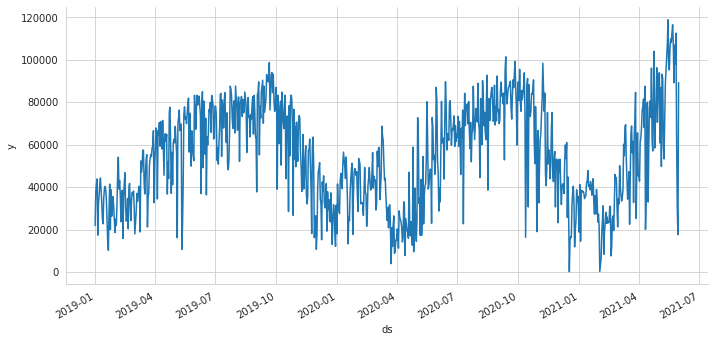

In [107]:
g = sns.relplot(x="ds", y="y", kind="line", data=bikes, aspect=2)
g.fig.autofmt_xdate()

Load weather data and create data for regressors.

In [108]:
weather = pd.read_csv(
    'data/weather.csv', 
    usecols=['STATION', 'NAME', 'DATE', 'PRCP', 'SNOW', 'SNWD'],
    dtype={'STATION': 'category', 'NAME': 'category'}
)
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [109]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73335 entries, 0 to 73334
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   STATION  73335 non-null  category      
 1   NAME     73335 non-null  category      
 2   DATE     73335 non-null  datetime64[ns]
 3   PRCP     72196 non-null  float64       
 4   SNOW     37394 non-null  float64       
 5   SNWD     17267 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(3)
memory usage: 2.5 MB


In [110]:
weather.sample()

,STATION,NAME,DATE,PRCP,SNOW,SNWD
9366,US1NJUN0010,"NEW PROVIDENCE 0.8 ESE, NJ US",2020-01-27,0.0,0.0,0.0


We will aggregate the data for the whole area by calculating the mean value from all the stations for a given day.

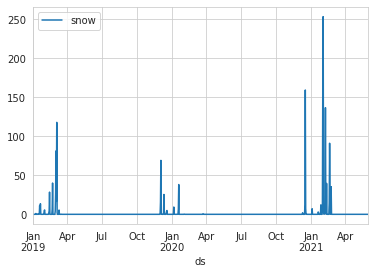

In [111]:
snowfall = weather.groupby('DATE', as_index=False).agg(snow=('SNOW', 'mean')).rename({'DATE': 'ds'}, axis=1)
snowfall.plot(x='ds', y='snow');

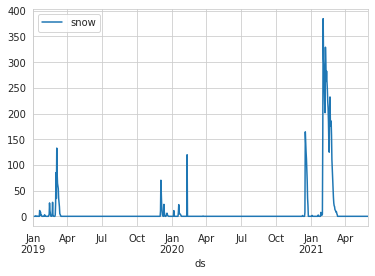

In [112]:
snow = weather.groupby('DATE', as_index=False).agg(snow=('SNWD', 'mean')).rename({'DATE': 'ds'}, axis=1)
snow.plot(x='ds', y='snow');

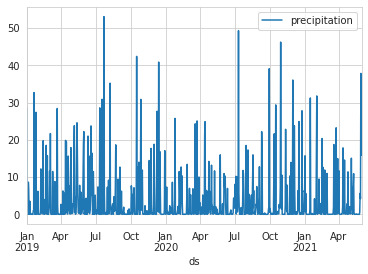

In [113]:
precipitation = weather.groupby('DATE', as_index=False) \
    .agg(precipitation=('PRCP', 'mean')) \
    .rename({'DATE': 'ds'}, axis=1)

precipitation.plot(x='ds', y='precipitation');

Combine data into one data frame.

In [114]:
data = pd.merge(bikes, snow, on='ds', how='outer')
data = pd.merge(data, precipitation, on='ds', how='outer')

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 881
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             882 non-null    datetime64[ns]
 1   y              881 non-null    float64       
 2   snow           882 non-null    float64       
 3   precipitation  882 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 34.5 KB


In [116]:
data[data.isnull().sum(axis=1) > 0]

,ds,y,snow,precipitation
881,2021-02-02,NaN,384.62,31.760345


It turns out we have no bike-sharing data for the 2nd of February 2021. But further investigation reveals New York was hit by heavy snowfall that day. So it actually may mean that not even one person used the bike during that time.

In [117]:
data = data.fillna(0)

Add information about the warm season of the year - from April to September.

In [118]:
data['on_season'] = data['ds'].dt.month.between(4, 9)
data['off_season'] = ~data['ds'].dt.month.between(4, 9)

Add information about the lockdown in NY when COVID pandemic started.

In [119]:
data['lockdown'] = data['ds'].between('2020-03-14', '2020-06-08')
data['usual'] = ~data['ds'].between('2020-03-14', '2020-06-08')

## Model the timeseries

Use cross validation to tune the parameters.

In [120]:
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

In [121]:
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)

In [122]:
def create_fit_model(
    data,
    changepoint_prior_scale=0.2,
#     seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    weekly_prior_scale=0.1,
    yearly_prior_scale=0.1,
    ):
    """Creates and fits a model with given parameters"""
    
    m = Prophet(
        n_changepoints=25,
        changepoint_range=0.9,
        changepoint_prior_scale=changepoint_prior_scale,
#         seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode='multiplicative',
        weekly_seasonality=False,
        yearly_seasonality=False,
    )
    m.add_country_holidays(country_name='US')
    m.add_regressor('precipitation')
    m.add_regressor('snow')
    m.add_seasonality(
        name='weekly_on_season', 
        period=7, 
        fourier_order=3, 
        prior_scale=weekly_prior_scale,  # 0.1, 
        condition_name='on_season'
    )
    m.add_seasonality(
        name='weekly_off_season', 
        period=7, 
        fourier_order=3, 
        prior_scale=weekly_prior_scale, 
        condition_name='off_season'
    )
    m.add_seasonality(
        name='yearly_lockdown', 
        period=365, 
        fourier_order=3, 
        prior_scale=yearly_prior_scale,  # 0.1, 
        condition_name='lockdown'
    )
    m.add_seasonality(
        name='yearly_usual', 
        period=365, 
        fourier_order=3, 
        prior_scale=yearly_prior_scale, 
        condition_name='usual'
    )

    m.fit(data)

    return m

In [123]:
def get_cross_validation_results(data, param_grid, cutoffs):
    """Do cross-validation and return results"""

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    rmses = []

    for num, params in enumerate(all_params):
        print(f'{num+1}/{len(all_params)}', params)

        m_cv = create_fit_model(data, **params)
        df_cv = cross_validation(m_cv, cutoffs=cutoffs, horizon='60 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    tuning_results = tuning_results.sort_values(by='rmse').reset_index(drop=True)

    return tuning_results

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'holidays_prior_scale': [0.1, 1., 10.],
    'weekly_prior_scale': [0.1, 1., 10.],
    'yearly_prior_scale': [0.1, 1., 10.],
}

cutoffs = pd.to_datetime(['2020-01-01', '2020-08-01', '2021-04-01'])

tuning_results = get_cross_validation_results(data, param_grid, cutoffs)

In [42]:
tuning_results.head(10)

,changepoint_prior_scale,holidays_prior_scale,weekly_prior_scale,yearly_prior_scale,rmse
0,0.01,10.0,0.1,1.0,17000.499453
1,0.01,1.0,10.0,0.1,17078.263351
2,0.01,10.0,0.1,0.1,17118.788924
3,0.01,0.1,10.0,1.0,17133.385892
4,0.01,1.0,1.0,10.0,17151.687736
5,0.01,1.0,0.1,1.0,17170.298084
6,0.01,10.0,1.0,0.1,17172.165614
7,0.01,10.0,10.0,0.1,17183.821768
8,0.01,0.1,10.0,10.0,17187.028370
9,0.01,1.0,1.0,1.0,17199.392240


Final choice of parameters:

In [43]:
params_final = tuning_results.iloc[0].drop('rmse').to_dict()
print(params_final)

{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'weekly_prior_scale': 0.1, 'yearly_prior_scale': 1.0}


## Create the final model

In [140]:
from prophet.plot import (
    plot_plotly, 
    plot_components_plotly, 
    plot_forecast_component_plotly,
    plot_seasonality_plotly
)

In [80]:
data.sample(5)

,ds,y,snow,precipitation,on_season,off_season,lockdown,usual
317,2019-11-14,54642.0,0.000000,0.006098,False,True,False,True
44,2019-02-14,41650.0,11.357143,0.094444,False,True,False,True
5,2019-01-06,31451.0,0.000000,6.621250,False,True,False,True
86,2019-03-28,58529.0,0.000000,0.000000,False,True,False,True
20,2019-01-21,10291.0,3.304348,3.902778,False,True,False,True


In [126]:
m = create_fit_model(data, **params_final)

In [127]:
forecast = m.predict(data)

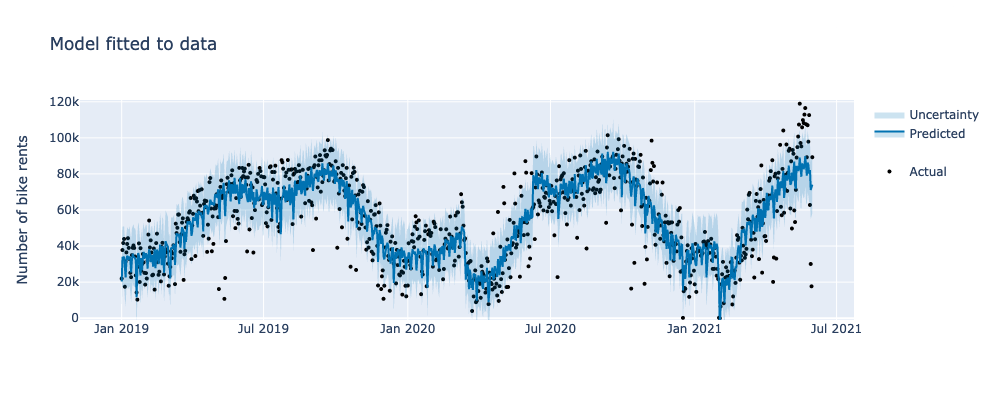

In [259]:
fig = plot_plotly(m, forecast, trend=False, changepoints=True)
fig.update_layout(
    title='Model fitted to data',
    showlegend=True,
    height=400,
    yaxis_range=[-1000, 121000],
    xaxis={'rangeslider': {'visible': False}, 'rangeselector': None, 'title': '', },
    yaxis={'title': 'Number of bike rents'}
)

new_names = {'trace 3': 'Uncertainty', 'trace 1': 'x', 'Predicted': 'Model', 'Actual': 'Actual'}
new_names = [None, 'Uncertainty', 'Predicted', ' ', 'Actual']
fig.for_each_trace(
    lambda trace: trace.update(name=new_names.pop()),
)

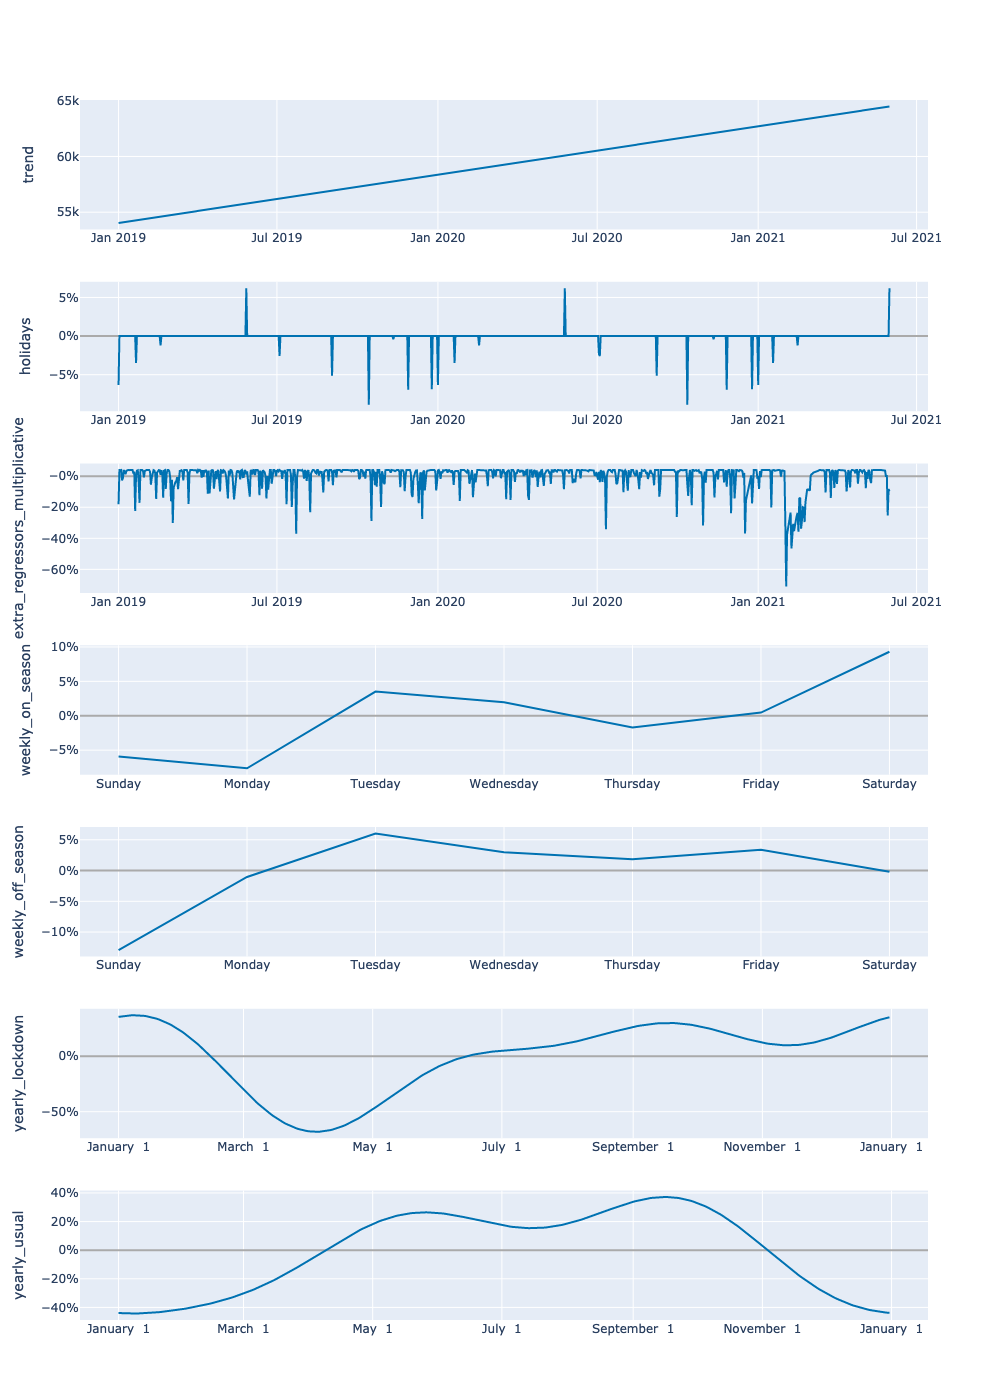

In [84]:
plot_components_plotly(m, forecast)

Check the forecast error distribution.

In [128]:
forecast['error'] = forecast['yhat'] - data['y']

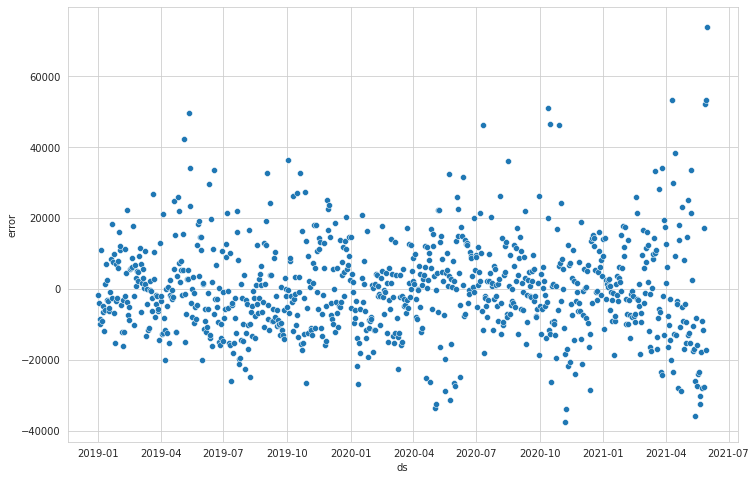

In [130]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='ds', y='error', data=forecast, ax=ax);

## Questions

In [131]:
import plotly.express as px

### What is the general trend of bike-sharing popularity?

In [132]:
trendplot = plot_forecast_component_plotly(m, forecast, 'trend');

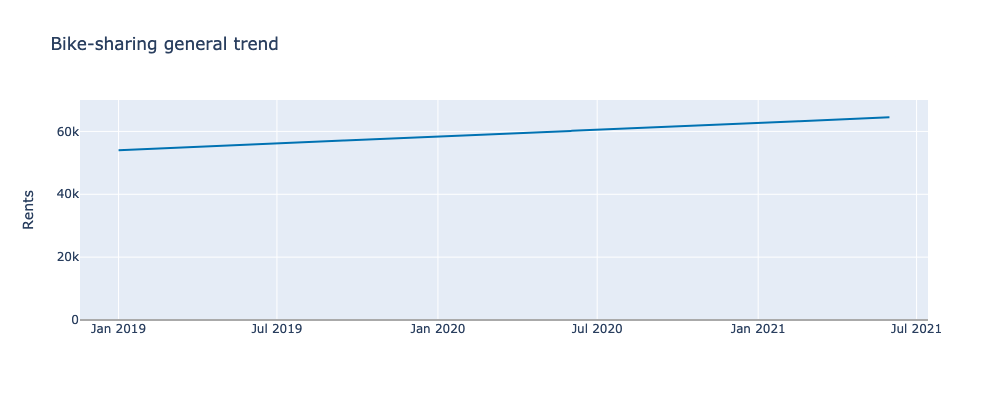

In [225]:
trendplot.update_layout(yaxis_range=[0, 70000], height=400, title='Bike-sharing general trend')
trendplot.update_yaxes(title='Rents')

The general trend has been steadily incrising since 2019.

### What are the yearly and weekly trends?

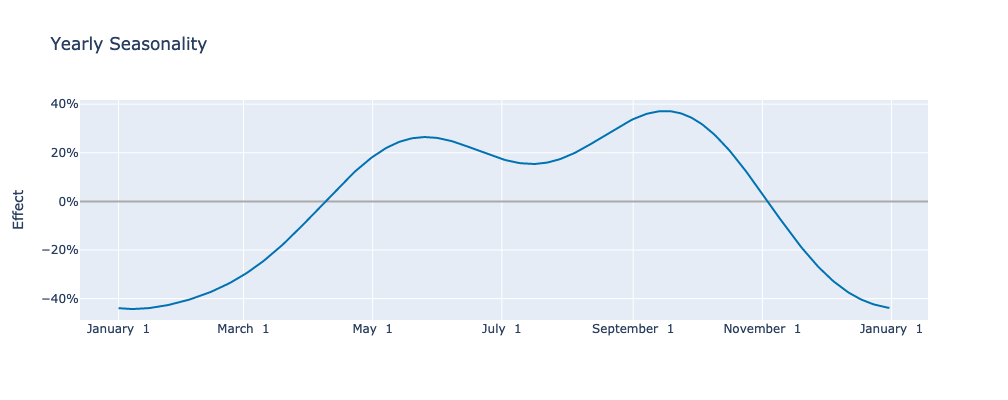

In [226]:
fig = plot_seasonality_plotly(m, 'yearly_usual')
fig.update_layout(title='Yearly Seasonality', height=400)
fig.update_yaxes(title='Effect')

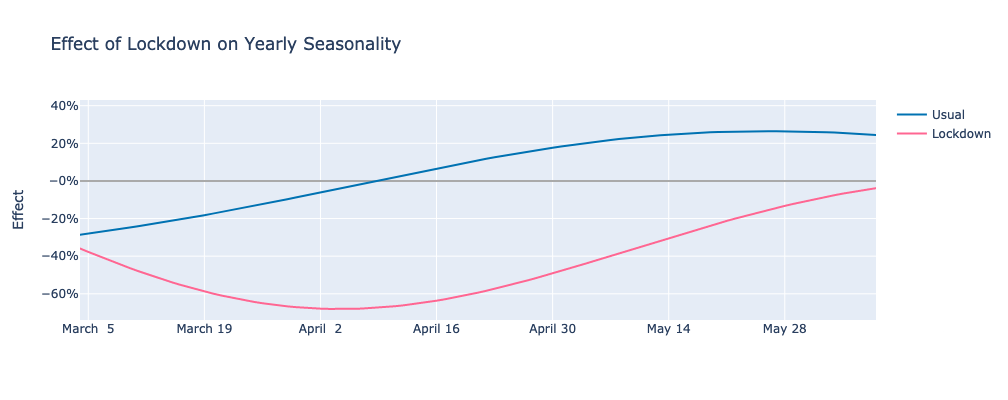

In [227]:
fig = plot_seasonality_plotly(m, 'yearly_usual').update_layout(xaxis_range=['2017-03-04', '2017-06-08'])
trace = plot_seasonality_plotly(m, 'yearly_lockdown').update_layout(xaxis_range=['2017-03-04', '2017-06-08'])['data'][0]
fig.add_trace(trace)
fig.update_layout(title='Effect of Lockdown on Yearly Seasonality', showlegend=True, height=400)
fig.update_yaxes(title='Effect')

new_names = {'yearly_lockdown': 'Lockdown', 'yearly_usual': 'Usual'}
new_colors = {'yearly_lockdown': '#FF6692', 'yearly_usual': '#0072B2'}
fig.for_each_trace(
    lambda trace: trace.update(name=new_names[trace.name], line={'color': new_colors[trace.name]}),
)
fig

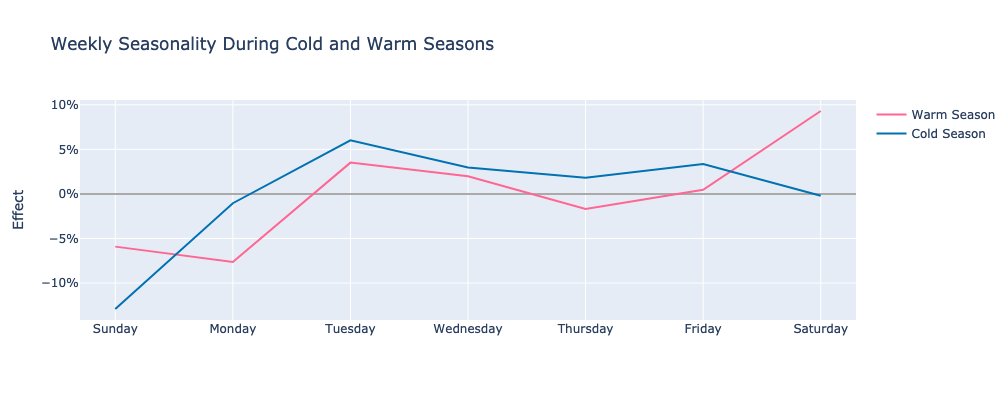

In [228]:
fig = plot_seasonality_plotly(m, 'weekly_on_season')
trace = plot_seasonality_plotly(m, 'weekly_off_season')['data'][0]
fig.add_trace(trace)
fig.update_layout(title='Weekly Seasonality During Cold and Warm Seasons', showlegend=True, height=400)
fig.update_yaxes(title='Effect')

new_names = {'weekly_on_season': 'Warm Season', 'weekly_off_season': 'Cold Season'}
new_colors = {'weekly_on_season': '#FF6692', 'weekly_off_season': '#0072B2'}
fig.for_each_trace(
    lambda trace: trace.update(name=new_names[trace.name], line={'color': new_colors[trace.name]}),
)
fig

### How do holidays influence the number of rents?

In [134]:
df_holidays = m.construct_holiday_dataframe(forecast['ds'])
_, _, holiday_names = m.make_holiday_features(forecast['ds'], df_holidays)

holiday_effect = forecast[holiday_names[:-3]].where(forecast[holiday_names[:-3]]!=0).mean()
holiday_effect = pd.DataFrame({'Holiday': holiday_effect.index, 'Effect': holiday_effect.values})

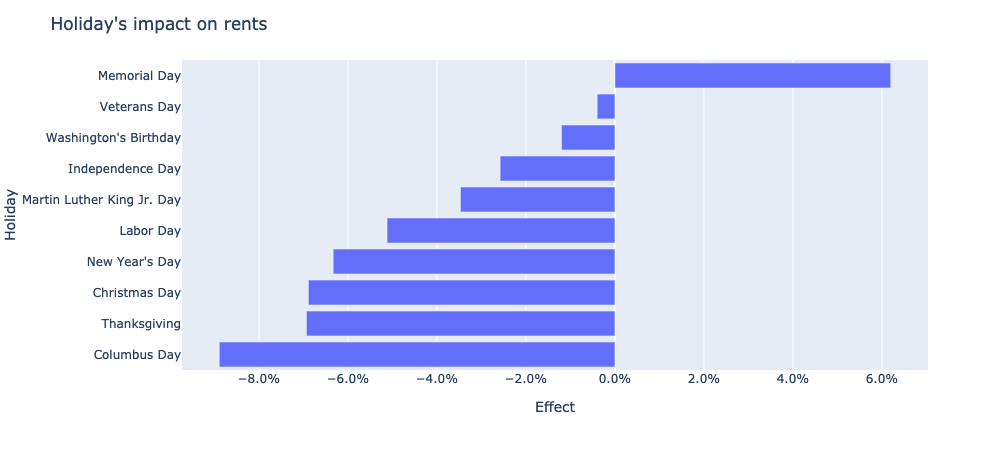

In [229]:
fig = px.bar(holiday_effect.sort_values(by='Effect'), x='Effect', y='Holiday')
fig.update_layout(xaxis_tickformat='.1%', title="Holiday's impact on rents")
fig.show()

### Were there any outliers?

It turns out we have no bike-sharing data for the 2nd of February 2021. But further investigation reveals New York was hit by heavy snowfall that day. So it actually may mean that not even one person used the bike during that time.

---